Pytorch没有官方的高阶API，一般需要用户自己实现训练循环、验证循环、和预测循环。

作者通过仿照tf.keras.Model的功能对Pytorch的nn.Module进行了封装，

实现了 fit, validate，predict, summary 方法，相当于用户自定义高阶API。

并在其基础上实现线性回归模型和DNN二分类模型。

In [1]:
import os
import datetime
from torchkeras import Model, summary

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

一、 线性回归模型

1. 准备数据

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [3]:
# 样本数量
n = 400

# 生成测试用数据集
X = 10 * torch.rand([n, 2]) - 5.0  # torch.rand 是均匀分布
w0 = torch.tensor([[2.0], [-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0 + b0 + torch.normal(0.0, 2.0, size=[n, 1])  # 表示矩阵乘法， 增加正态扰动

In [5]:
# 构建输入数据管道

ds = TensorDataset(X, Y)
ds_train, ds_valid = torch.utils.data.random_split(ds, [int(400*0.7), 400-int(400*0.7)])
dl_train = DataLoader(ds_train, batch_size=10, shuffle=True, num_workers=2)
dl_valid = DataLoader(ds_valid, batch_size=10, num_workers=2)

2. 定义模型

In [6]:
# 继承用户自定义模型

from torchkeras import Model
class LinearRegression(Model):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2, 1)

    def forward(self, x):
        return self.fc(x)

model = LinearRegression()

In [7]:
model.summary(input_shape=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               3
Total params: 3
Trainable params: 3
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000008
Params size (MB): 0.000011
Estimated Total Size (MB): 0.000027
----------------------------------------------------------------


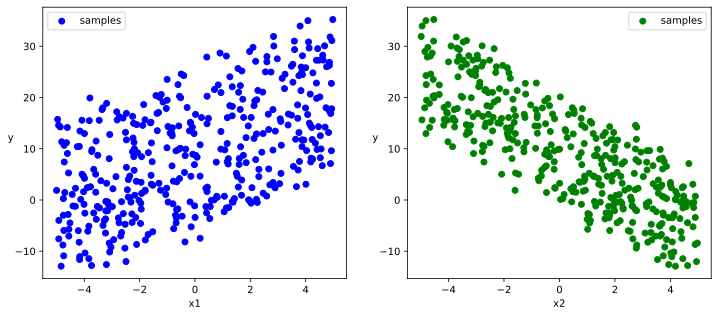

In [8]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

3. 训练模型

In [14]:
# 使用fit 方法进行训练

def mean_absolute_error(y_pred, y_true):
    return torch.mean(torch.abs(y_pred - y_true))

def mean_absolute_percent_error(y_pred, y_true):
    absolute_percent_error =  (torch.abs(y_pred - y_true) + 1e-7 / (torch.abs(y_true) + 1e-7))
    return torch.mean(absolute_percent_error)

optim = torch.optim.Adam(model.parameters(), lr=0.01)

model.compile(loss_func=nn.MSELoss(), optimizer=optim, metrics_dict={'mae':mean_absolute_error, 'mape':mean_absolute_percent_error})

dfhistroy = model.fit(200, dl_train=dl_train, dl_val=dl_valid, log_step_freq=20)

s': 4.164, 'mae': 1.638, 'mape': 1.638}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  160  | 3.876 | 1.559 | 1.559 |  3.969   |  1.569  |  1.569   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2020-10-20 13:58:53
{'step': 20, 'loss': 4.131, 'mae': 1.595, 'mape': 1.595}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  161  | 3.842 | 1.556 | 1.556 |  3.892   |  1.558  |  1.558   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2020-10-20 13:58:55
{'step': 20, 'loss': 3.705, 'mae': 1.

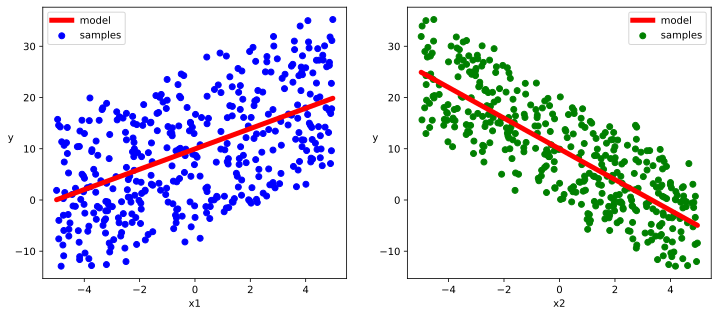

In [18]:
# 结果可视化

w, b = model.state_dict()['fc.weight'], model.state_dict()['fc.bias']

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:, 0], c='b', label='samples')
ax1.plot(X[:, 0], w[0,0]*X[:, 0] + b[0], '-r', linewidth=5.0, label='model')
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y', rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[0,1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

4. 评估模型

In [19]:
dfhistroy.tail()

,loss,mae,mape,val_loss,val_mae,val_mape
195,3.857892,1.561266,1.561266,3.921227,1.563308,1.563308
196,3.868131,1.560093,1.560093,3.883389,1.555629,1.555629
197,3.852792,1.557850,1.557850,3.948743,1.565923,1.565923
198,3.848008,1.557949,1.557949,3.920734,1.562119,1.562119
199,3.859701,1.560045,1.560045,3.846694,1.549101,1.549101


In [20]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

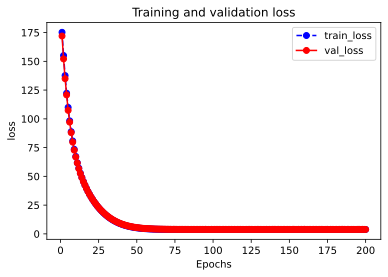

In [22]:
plot_metric(dfhistroy,"loss")

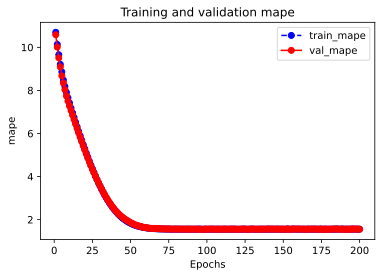

In [24]:
plot_metric(dfhistroy,"mape")


In [25]:
# 评估
model.evaluate(dl_valid)

{'val_loss': 3.8466937939325967,
 'val_mae': 1.5491012533505757,
 'val_mape': 1.5491012732187908}

5. 使用模型

In [26]:
# 预测
dl = DataLoader(TensorDataset(X))
model.predict(dl)[0:10]

tensor([[ 7.2789],
        [-2.3545],
        [15.8531],
        [10.1199],
        [ 7.5379],
        [ 0.5279],
        [23.4435],
        [27.0310],
        [10.2484],
        [15.0243]])

In [27]:
# 预测
model.predict(dl_valid)[0:10]

tensor([[14.6937],
        [-3.0927],
        [12.6107],
        [-2.0860],
        [-7.8847],
        [ 2.9801],
        [11.2381],
        [ 3.6138],
        [ 1.7635],
        [-0.9897]])